# Experiments on synthetic data

Code to obtain the results in Section 4 of NeurIPS 2021 Paper6977 submission,
for the proposed Conformal RNN model. This also briefly reviews the code to run the
BJRNN baseline.

In [1]:
%load_ext autoreload

%autoreload 2

Required imports

In [40]:
import numpy as np
import pickle
import torch

from matplotlib import pyplot as plt
%matplotlib inline

from utils.train_synthetic import run_synthetic_experiments, load_synthetic_results
from utils.results import *

In [3]:
BASELINES = ['QRNN', 'DPRNN', 'CFRNN', 'CFRNN_normalised']

## Time-dependent noise profile (Figure 3, Table 2)

Training procedure for CF-RNN/MQ-RNN/DP-RNN baselines (for 5 different seeds):

In [14]:
for baseline in ['CFRNN_normalised']:
    for seed in range(1):
        run_synthetic_experiments(experiment='time_dependent', 
                                  baseline=baseline,
                                  retrain=True,
                                  cached_datasets=False,
                                  save_model=True, 
                                  save_results=True,
                                  rnn_mode='LSTM',
                                  seed=seed)

Training CFRNN_normalised
Training dataset 0
Epoch: 0	Normalisation loss: 1.6359372973442077
Epoch: 100	Normalisation loss: 1.2723908424377441
Epoch: 200	Normalisation loss: 1.2516960620880127
Epoch: 300	Normalisation loss: 1.2170039892196656
Epoch: 400	Normalisation loss: 1.184722626209259
Epoch: 500	Normalisation loss: 1.1584922432899476
Epoch: 600	Normalisation loss: 1.1374752700328827
Epoch: 700	Normalisation loss: 1.1189534366130829
Epoch: 800	Normalisation loss: 1.0971182823181151
Epoch: 900	Normalisation loss: 1.0757525384426116
Training dataset 1
Epoch: 0	Normalisation loss: 1.9092247009277343
Epoch: 100	Normalisation loss: 1.3015767097473145
Epoch: 200	Normalisation loss: 1.287161922454834
Epoch: 300	Normalisation loss: 1.2733166217803955
Epoch: 400	Normalisation loss: 1.257886528968811
Epoch: 500	Normalisation loss: 1.2390721082687377
Epoch: 600	Normalisation loss: 1.2227744519710542
Epoch: 700	Normalisation loss: 1.2071114659309388
Epoch: 800	Normalisation loss: 1.1901608943

Evaluation:

**Joint coverage**

Prints mean joint coverage across the horizon (mean±std for 5 random seeds)

In [41]:
for baseline in ['CFRNN', 'CFRNN_normalised']:
    print(baseline)
    coverages_mean, coverages_std = get_joint_coverages(baseline, 'time_dependent')
    
    for m, s in zip(coverages_mean, coverages_std):
        print('{:.1f} \\(\\pm\\) {:.1f}\\%'.format(m, s))
    print()

CFRNN
92.7 \(\pm\) 1.3\%
92.4 \(\pm\) 0.9\%
90.9 \(\pm\) 1.3\%
90.6 \(\pm\) 1.2\%
91.1 \(\pm\) 0.7\%
CFRNN_normalised
92.0 \(\pm\) 1.6\%
92.5 \(\pm\) 0.6\%
91.0 \(\pm\) 1.2\%
91.2 \(\pm\) 2.1\%
91.4 \(\pm\) 1.6\%


**Interval widths**

Prints the baseline; mean±std of interval width across horizons; rows denote the noise configuration and columns the random seed. 

In [42]:
for baseline in ['CFRNN', 'CFRNN_normalised']:
    print(baseline)
    widths_mean, widths_std = get_interval_widths(baseline, 'time_dependent')
    
    print(widths_mean)
    print()

CFRNN
[[14.0667078  17.85527916 20.80839233 21.9628231  24.2872036 ]
 [21.00781212 23.86641617 25.95785027 28.03909607 29.85377998]
 [27.07062569 30.69322357 32.29739532 35.88821259 37.5401268 ]
 [34.86802292 38.12249603 40.785186   44.00330658 45.93652191]
 [41.06905746 45.63201599 49.84396133 51.83349075 56.61880722]]

CFRNN_normalised
[[14.67151928 18.29293747 21.42110558 23.79222031 25.92886047]
 [21.77542381 24.77155724 27.49373741 28.75037079 33.01145592]
 [28.62307281 31.41215515 33.61304131 37.99287796 40.64476395]
 [38.32217712 39.96359787 44.12059937 47.14330292 48.38878555]
 [44.04530487 47.96414108 53.99875717 56.26520004 60.00620651]]



## Static noise, no periodic component (Table ?)

## Periodic component (Figure ?)

## Plotting

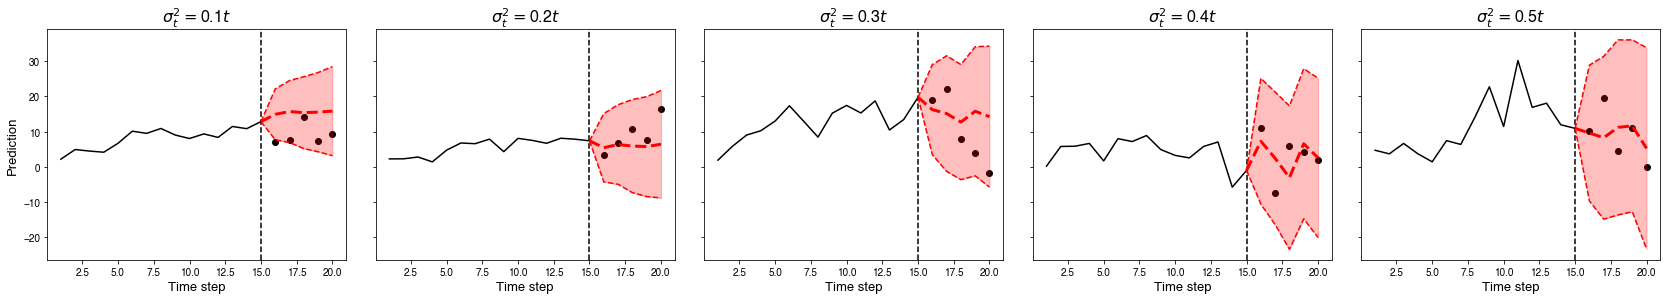

In [45]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN', index=range(1))

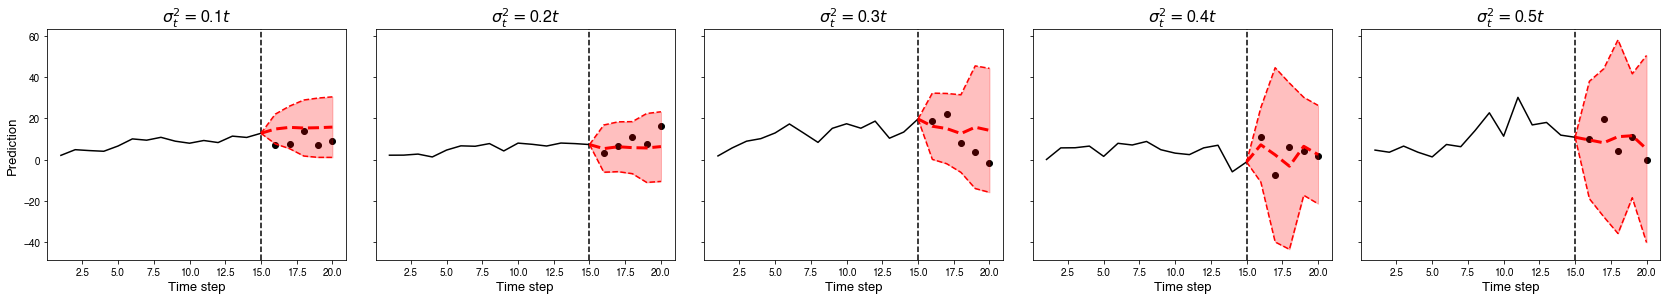

In [46]:
plot_timeseries(experiment='time_dependent', baseline='CFRNN_normalised', index=range(1))

## Long horizon analysis (Figure 4)

Training code for the three underlying RNN models:

In [ ]:
from utils.train_synthetic import run_synthetic_experiments
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='GRU')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='RNN')
run_synthetic_experiments(experiment='long-horizon', retrain=True, save_model=True, save_results=False, rnn_mode='LSTM')

Analyzing interval widths:

In [ ]:
import torch
widths = {}
for rnn_model in ['LSTM', 'RNN', 'GRU']:
    model = torch.load('saved_models/long-horizon_CPRNN_{}_100.pt'.format(rnn_model))
    
    ws = []
    alphas = np.arange(100) * 0.01
    for alpha in alphas:
        corrected_alpha = alpha / model.horizon
        corrected_critical_calibration_scores = torch.tensor([[
                torch.quantile(
                    position_calibration_scores,
                    q=1 - corrected_alpha * model.n_train / (model.n_train + 1))
                for position_calibration_scores in feature_calibration_scores]
                for feature_calibration_scores in model.calibration_scores]).T
        ws.append(corrected_critical_calibration_scores.flatten().tolist())
    ws = np.array(ws)
    ws = ws * 2
    widths[rnn_model] = ws

In [ ]:
def compute_valid_horizons(threshold_width=15):
    valid_horizons = {}
    for rnn_model in ['LSTM', 'RNN', 'GRU']:    
        T = []
        ws = widths[rnn_model]
        for i, _ in enumerate(alphas):
            t = 0
            while t < ws.shape[1] and ws[i, t] < threshold_width:
                t += 1
            T.append(t)
        valid_horizons[rnn_model] = np.array(T)
    return valid_horizons

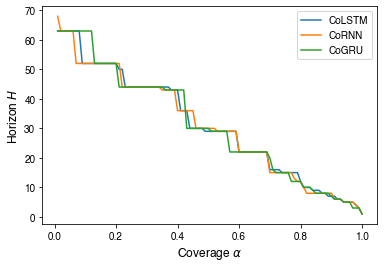

In [132]:
for threshold_width in [16]:
    valid_horizons = compute_valid_horizons(threshold_width)
    for rnn_model in valid_horizons.keys():
        plt.plot(1-alphas, valid_horizons[rnn_model], label='Co{}'.format(rnn_model))
plt.xlabel('Coverage $1-\\alpha$')
plt.ylabel('Horizon $H$')
plt.legend()
plt.savefig('{}.png'.format('tradeoff') , bbox_inches='tight', dpi=1000)
plt.show()

## BJRNN baseline

Example for training the time-dependent noise profile, for a single seed.

In [ ]:
from utils.train_synthetic import train_bjrnn
results = train_bjrnn(noise_mode='time-dependent')